In [2]:
import wave as wave
import numpy as np
import scipy.signal as sg
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c):
    # ysinΘ + xcosΘ
    """
    a: i x n_mic x 1 x n_bin
       方向数 x マイク数 x 1 x 周波数ビン数
    """
    rc = 0.0365
    mic_angle = np.array(
        [
            0,
            -np.pi / 4,
            -np.pi / 2,
            -np.pi * 3 / 4,
            np.pi,
            np.pi * 3 / 4,
            np.pi * 1 / 2,
            np.pi * 1 / 4,
        ]
    )
    a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64)
    for i, th in enumerate(theta):
        th = np.radians(th)
        for k in range(n_bin):
            fk = fs * k / N
            for m in range(n_mic):
                delay = -rc * np.cos(th - mic_angle[m]) / c
                a[i, m, 0, k] = np.exp(-1j * 2 * np.pi * fk * delay)
    return a


def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    # print("sample width:", wav.getsampwidth())
    # print("channel num:", wav.getnchannels())
    # print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    # print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data


def lower_bound(arr, num):
    left = 0
    right = len(arr) - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] <= num:
            left = mid + 1
        if arr[mid] > num:
            right = mid - 1
    # print("left: ", left, " right: ", right)
    return right


def MUSIC(file_name, t_left_sec, t_right_sec, start_angle, end_angle):
    n_mic = 8
    n_src = 3
    N = 512
    window = "hann"
    c = 340
    freq_l = 800
    freq_h = 3000

    fs = 16000
    k_l = int(freq_l / (fs / N))
    k_h = int(freq_h / (fs / N))

    audio = load_onefile(file_name)

    # print(audio.shape)
    f, t, X = sg.stft(audio, fs, window=window, nperseg=N)
    n_bin = X.shape[1]
    # print(t)
    t_left_index = lower_bound(t, t_left_sec)
    t_right_index = lower_bound(t, t_right_sec)

    theta = np.linspace(
        start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1
    )
    P_MU = np.zeros(theta.shape[0])

    a = calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c)
    # print(X.shape)
    X_trimed = X[:, :, t_left_index:t_right_index]
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    eig_val = np.zeros((n_mic, n_bin), dtype=np.complex64)
    eig_vec = np.zeros((n_mic, n_mic, n_bin), dtype=np.complex64)
    beta = np.zeros(n_bin)
    for k in range(n_bin):
        eig_val_k, eig_vec_k = np.linalg.eig(
            R[:, :, k]
        )  # 周波数ごとに固有値、固有ベクトルを算出
        sort = np.argsort(-1.0 * np.abs(eig_val_k))
        eig_val[:, k] = eig_val_k[sort]
        eig_vec[:, :, k] = eig_vec_k[:, sort]

    W = eig_vec[:, n_src:, :]
    beta = np.sum(np.abs(eig_val[:n_src, :]), axis=0)

    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHa = np.einsum("mik,mjk->ijk", aH, a[i])
        P_MU_th = np.einsum("mik,mek->iek", aH, W)
        P_MU_th = np.einsum("iek,jek->ijk", P_MU_th, np.conjugate(P_MU_th))
        P_MU_th = np.abs(aHa) / np.abs(P_MU_th)
        P_MU[i] = np.mean(beta[k_l : k_h + 1] * P_MU_th[0, 0, k_l : k_h + 1])

    P_MU = 10 * np.log10(P_MU)

    return P_MU

In [4]:
string_list = np.array(
    [
        "step_left600",
        "step_left450",
        "step_left300",
        "step_left150",
        "step_front0",
        "step_right150",
        "step_right300",
        "step_right450",
        "step_right600",
    ],
    dtype=f"<U{50}",
)

file_list = np.empty((4, string_list.shape[0]), dtype=f"<U{50}")

for i in range(4):
    dist = (i + 1) * 50
    file_list[i] = [string + "_" + str(dist) + "_0" for string in string_list]

print(file_list)

dir_name = str(Path.cwd().parent) + "/step_corner_datas/"
# file_body = "whitenoise_60"
# dir_name = str(Path.cwd().parent) + "/whitenoise/"

file_list_path = np.char.add(dir_name, file_list)
file_list_path = np.char.add(file_list_path, ".wav")

print(file_list_path)

[['step_left600_50_0' 'step_left450_50_0' 'step_left300_50_0'
  'step_left150_50_0' 'step_front0_50_0' 'step_right150_50_0'
  'step_right300_50_0' 'step_right450_50_0' 'step_right600_50_0']
 ['step_left600_100_0' 'step_left450_100_0' 'step_left300_100_0'
  'step_left150_100_0' 'step_front0_100_0' 'step_right150_100_0'
  'step_right300_100_0' 'step_right450_100_0' 'step_right600_100_0']
 ['step_left600_150_0' 'step_left450_150_0' 'step_left300_150_0'
  'step_left150_150_0' 'step_front0_150_0' 'step_right150_150_0'
  'step_right300_150_0' 'step_right450_150_0' 'step_right600_150_0']
 ['step_left600_200_0' 'step_left450_200_0' 'step_left300_200_0'
  'step_left150_200_0' 'step_front0_200_0' 'step_right150_200_0'
  'step_right300_200_0' 'step_right450_200_0' 'step_right600_200_0']]
[['/home/nishimura-k/audioprocessing/step_corner_datas/step_left600_50_0.wav'
  '/home/nishimura-k/audioprocessing/step_corner_datas/step_left450_50_0.wav'
  '/home/nishimura-k/audioprocessing/step_corner_datas/s

Not found:  step_front0_50_0
Not found:  step_front0_150_0
Not found:  step_left600_200_0


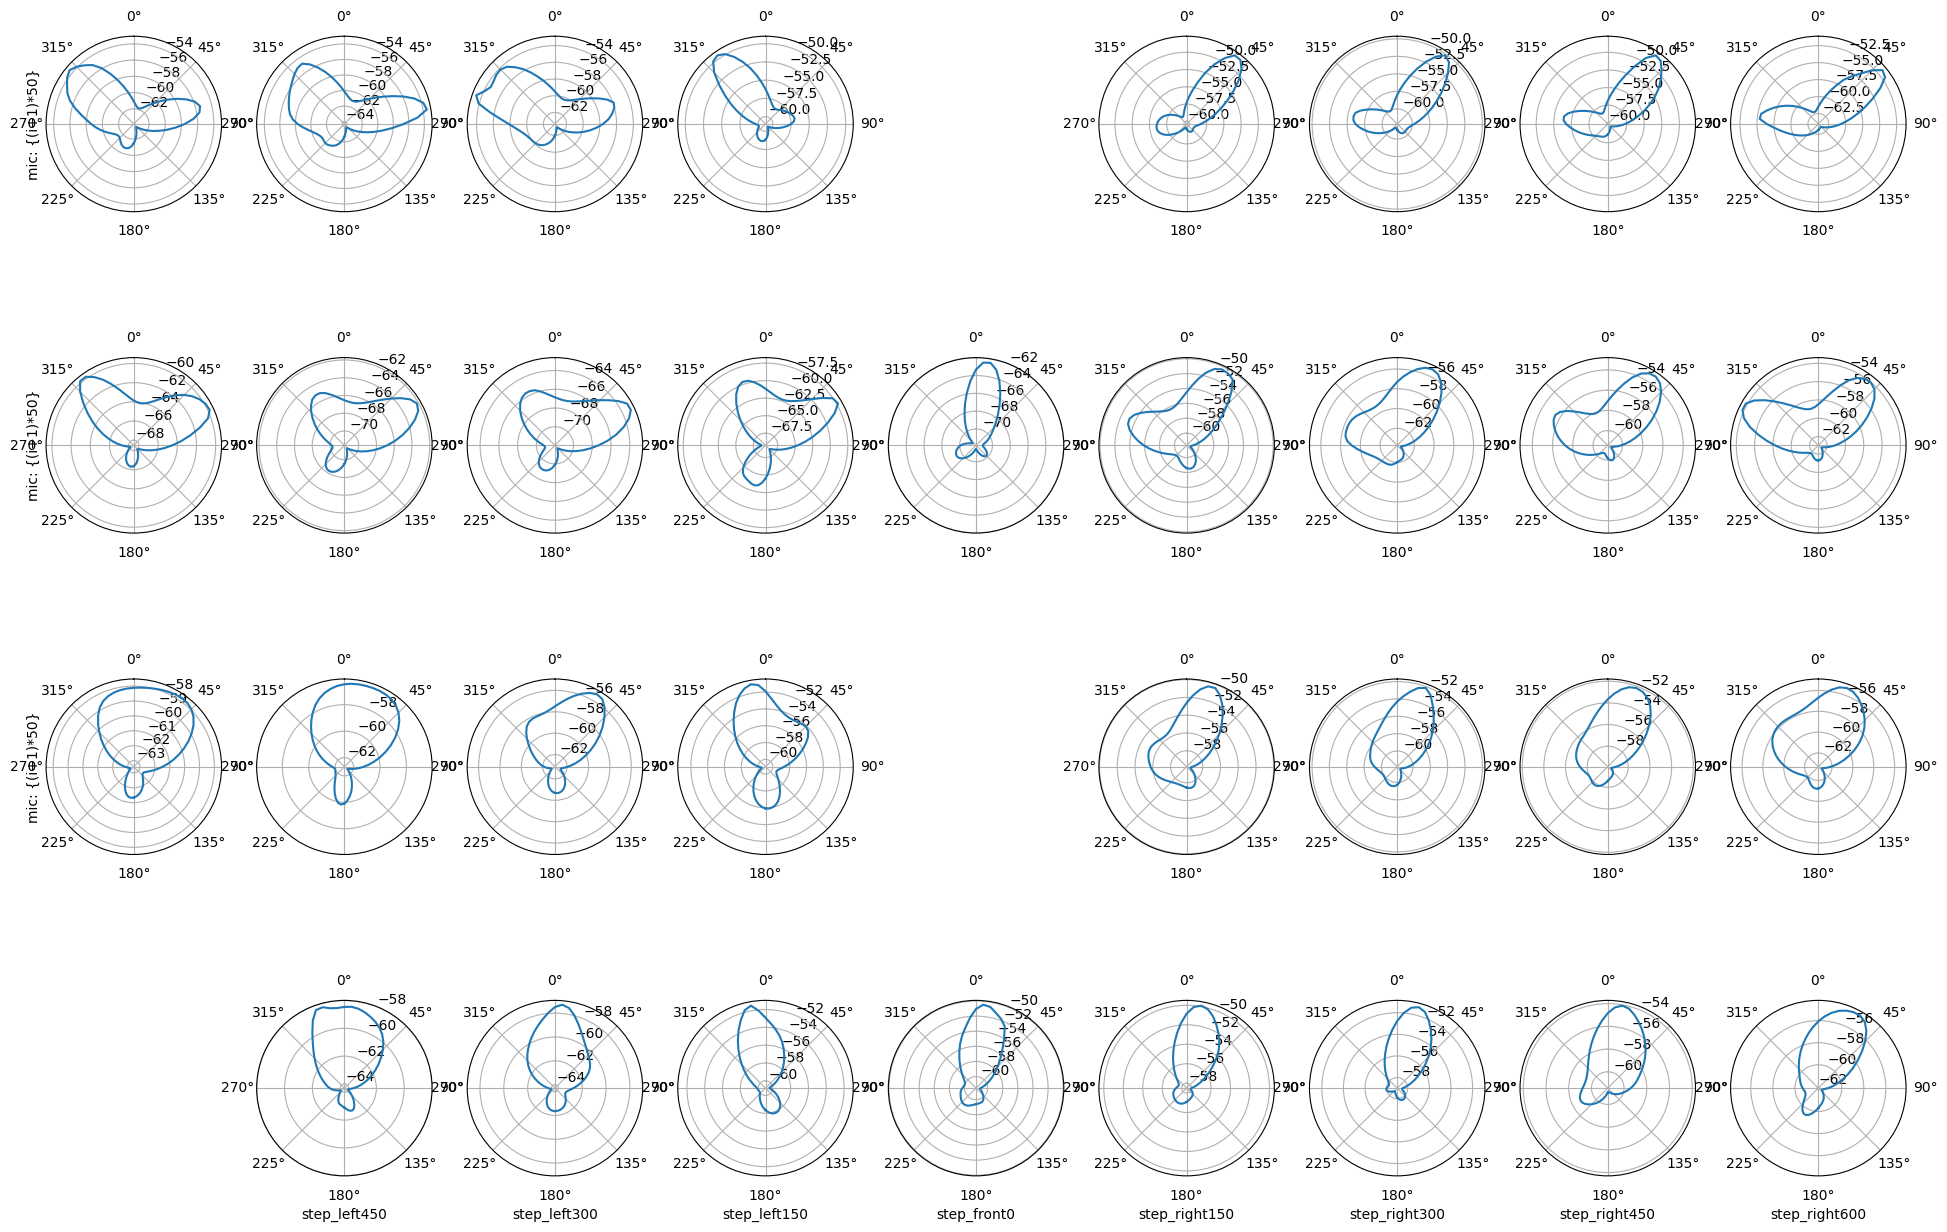

In [7]:
plt.figure(figsize=(24, 16))

row_count = file_list_path.shape[0]
col_count = file_list_path.shape[1]

start_angle = -180
end_angle = 180
t_left_sec = 15
t_right_sec = 26
theta = np.linspace(start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1)
theta = np.deg2rad(theta)

for i in range(row_count):
    for j, file_name in enumerate(file_list_path[i]):
        try:
            P_MU = MUSIC(
                file_name, t_left_sec=t_left_sec, t_right_sec=t_right_sec, start_angle=-180, end_angle=180
            )
            ax = plt.subplot(
                row_count, col_count, (col_count) * i + j + 1, projection="polar"
            )
            ax.plot(theta, P_MU)
            ax.set_theta_zero_location("N")
            ax.set_theta_direction(-1)
            if j == 0:
                ax.set_ylabel("mic: {(i+1)*50}")
            if i == row_count - 1:
                ax.set_xlabel(string_list[j])
        except FileNotFoundError:
            print("Not found: ", file_list[i, j])

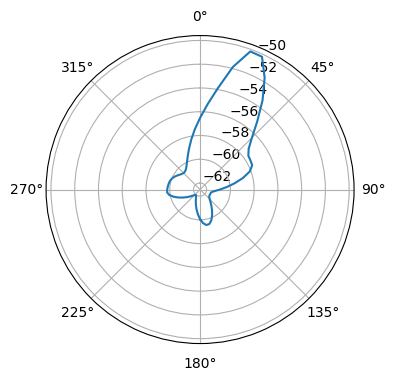

In [6]:
plt.figure(figsize=(10,4))
start_angle = -180
end_angle = 180
t_left_sec = 16.0
t_right_sec = 16.8
theta = np.linspace(start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1)
theta = np.deg2rad(theta)

file_name = str(Path.cwd().parent) + "/step_corner_datas/" + "walk_left600toright600_50_0.wav"
P_MU = MUSIC(file_name, t_left_sec, t_right_sec, start_angle=start_angle, end_angle=end_angle)
ax = plt.subplot(111, projection="polar")
ax.plot(theta, P_MU)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


In [3]:
np.save("P_MU_sample.npy", P_MU)

plt.figure()
plt.plot(theta, P_MU, marker="o", linestyle="-", color="b")
plt.title("Spatial Spectrum")
plt.xlabel("Theta (degrees)")
plt.ylabel("P_MU Value")
plt.grid(True)
plt.xticks(np.arange(-180, 181, 20))
plt.yticks(np.linspace(np.min(P_MU), np.max(P_MU), 10))
plt.show()

NameError: name 'np' is not defined

NameError: name 'audio' is not defined

<Figure size 640x480 with 0 Axes>